In [10]:
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pygsp import graphs, filters
import pickle
from scipy.sparse import csr_matrix
%matplotlib inline

In [4]:
data= pd.read_csv('archive/jams.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')

b'Skipping line 58038: expected 7 fields, saw 8\nSkipping line 58738: expected 7 fields, saw 8\n'
b'Skipping line 847113: expected 7 fields, saw 8\n'
b'Skipping line 1091137: expected 7 fields, saw 8\nSkipping line 1175359: expected 7 fields, saw 8\n'
b'Skipping line 1225919: expected 7 fields, saw 8\nSkipping line 1255341: expected 7 fields, saw 8\nSkipping line 1279655: expected 7 fields, saw 8\n'
b'Skipping line 1330659: expected 7 fields, saw 8\n'
b'Skipping line 1448017: expected 7 fields, saw 8\nSkipping line 1543877: expected 7 fields, saw 8\n'
b'Skipping line 1579553: expected 7 fields, saw 8\nSkipping line 1612432: expected 7 fields, saw 8\n'
b'Skipping line 1784572: expected 7 fields, saw 8\n'


In [5]:
data.head(5)

,jam_id,user_id,artist,title,creation_date,link,spotify_uri
0,c2e76bb92c7fa733fdfc9be40bb0e4ea,b99ebf68a8d93f024e56c65e2f949b57,Orange Juice,Rip It Up,2011-08-26,NaN,spotify:track:6AGhDIyDbRonzGTdbIsNXa
1,5d2bc46196d7903a5580f0dbedc09610,c1066039fa61eede113878259c1222d1,Erkin Koray,Hele Yar,2011-08-26,NaN,NaN
2,4849f8c893a792032dbc15eb77cfd0cd,d8a96caeef5c7d8dbdc9cec28aa9c044,Stereo,Somewhere In the Night,2011-08-26,NaN,spotify:track:2ZM9sVP0blBj1lNIEg4dgn
3,8940ff2e8e38c8f1a4676e09d152c0cd,b1c81a51f5286d70e5820ecb85aeba96,The Mills Brothers,I Got Her Off My Hands,2011-08-26,NaN,spotify:track:096elxAmYuyAFJKPLrS5oY
4,4020b45a4c6d5515a3b62c489e169828,4fdc0257bc476bffd3e73564ecaa75e0,Various,Zum Volksfest,2011-08-26,NaN,NaN


In [9]:
net = pd.read_csv('archive/followers.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')

In [10]:
net.head(5)

,followed_user_id,follower_user_id
0,b99ebf68a8d93f024e56c65e2f949b57,1ebda3c5e05265626ab18401fb33a90a
1,c1066039fa61eede113878259c1222d1,1ebda3c5e05265626ab18401fb33a90a
2,d8a96caeef5c7d8dbdc9cec28aa9c044,1ebda3c5e05265626ab18401fb33a90a
3,2969c319775d884b860a897ba9d6156f,1ebda3c5e05265626ab18401fb33a90a
4,ff58e67948917e0ff71ba4b33e158365,1ebda3c5e05265626ab18401fb33a90a


In [11]:
followed=list(net['followed_user_id'].unique())

In [12]:
followers=list(net['follower_user_id'].unique())

In [13]:
nodes=list(set(followed+followers))

In [40]:
follow_graph = nx.Graph()
follow_graph.add_nodes_from(nodes)

In [41]:
for i in tqdm(range(len(net))):
    follow_graph.add_edge(net['followed_user_id'].iloc[i],net['follower_user_id'].iloc[i],weight=1)

100%|██████████| 1603404/1603404 [01:42<00:00, 15606.87it/s]


In [16]:
degrees = np.array(list(dict(nx.degree(follow_graph)).values()))

(array([  1.01250000e+05,   1.70000000e+01,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   5.31200000e+03,   1.06230000e+04,
          1.59340000e+04,   2.12450000e+04,   2.65560000e+04,
          3.18670000e+04,   3.71780000e+04,   4.24890000e+04,
          4.78000000e+04,   5.31110000e+04]),
 <a list of 10 Patch objects>)

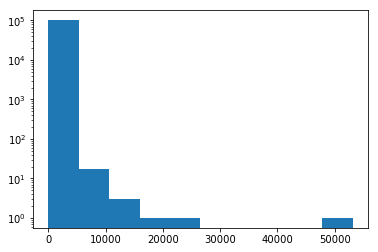

In [17]:
plt.hist(degrees, log=True)

(array([ 43181.,  18964.,  10179.,   6293.,   3746.,   3602.,   2490.,
          1908.,   1359.,   1093.]),
 array([  1. ,   5.8,  10.6,  15.4,  20.2,  25. ,  29.8,  34.6,  39.4,
         44.2,  49. ]),
 <a list of 10 Patch objects>)

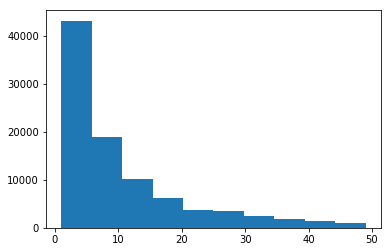

In [18]:
small_degrees = degrees[degrees < 50]
plt.hist(small_degrees)

In [19]:
nx.is_connected(follow_graph)

False

In [20]:
#Here we will keep the greatest component Gcc[0] for the further analysis
Gcc=sorted(nx.connected_component_subgraphs(follow_graph), key = len, reverse=True)

In [21]:
len(Gcc[0])

100518

In [22]:
giant_comp = nx.adjacency_matrix(Gcc[0])

In [24]:
giant_comp.setdiag(0)

/Users/antoinewehenkel/anaconda/lib/python3.5/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [25]:
giant_comp_graph = graphs.Graph(giant_comp)

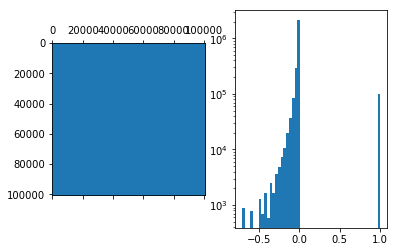

In [26]:
giant_comp_graph.compute_laplacian('normalized')

fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=0.6)
axes[1].hist(G.L.data, bins=50, log=True);

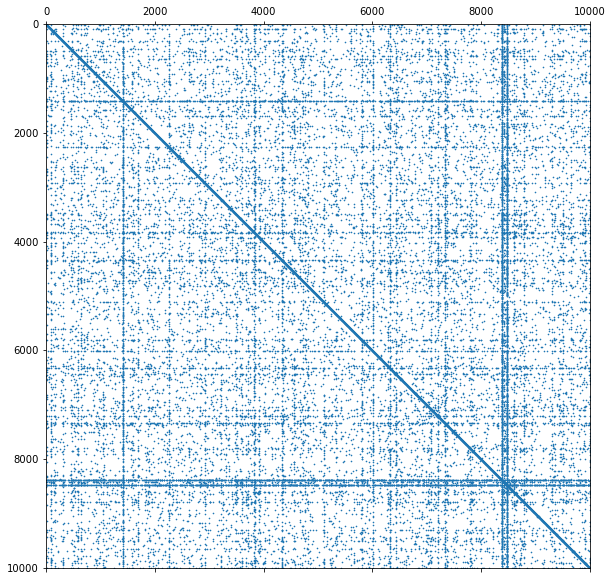

In [27]:
plt.figure(figsize=(10,10))
plt.spy(giant_comp_graph.L[0:10000,  0:10000],markersize=0.6)

In [29]:
likes = pd.read_csv('archive/likes.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')

In [30]:
likes.head()

,user_id,jam_id
0,c1066039fa61eede113878259c1222d1,5d2bc46196d7903a5580f0dbedc09610
1,b99ebf68a8d93f024e56c65e2f949b57,8940ff2e8e38c8f1a4676e09d152c0cd
2,c1066039fa61eede113878259c1222d1,4849f8c893a792032dbc15eb77cfd0cd
3,c1066039fa61eede113878259c1222d1,4020b45a4c6d5515a3b62c489e169828
4,b99ebf68a8d93f024e56c65e2f949b57,4849f8c893a792032dbc15eb77cfd0cd


In [31]:
data.head()

,jam_id,user_id,artist,title,creation_date,link,spotify_uri
0,c2e76bb92c7fa733fdfc9be40bb0e4ea,b99ebf68a8d93f024e56c65e2f949b57,Orange Juice,Rip It Up,2011-08-26,NaN,spotify:track:6AGhDIyDbRonzGTdbIsNXa
1,5d2bc46196d7903a5580f0dbedc09610,c1066039fa61eede113878259c1222d1,Erkin Koray,Hele Yar,2011-08-26,NaN,NaN
2,4849f8c893a792032dbc15eb77cfd0cd,d8a96caeef5c7d8dbdc9cec28aa9c044,Stereo,Somewhere In the Night,2011-08-26,NaN,spotify:track:2ZM9sVP0blBj1lNIEg4dgn
3,8940ff2e8e38c8f1a4676e09d152c0cd,b1c81a51f5286d70e5820ecb85aeba96,The Mills Brothers,I Got Her Off My Hands,2011-08-26,NaN,spotify:track:096elxAmYuyAFJKPLrS5oY
4,4020b45a4c6d5515a3b62c489e169828,4fdc0257bc476bffd3e73564ecaa75e0,Various,Zum Volksfest,2011-08-26,NaN,NaN


In [32]:
merge = likes.merge(data[['jam_id','user_id']],on='jam_id')

In [33]:
merge.head()

,user_id_x,jam_id,user_id_y
0,c1066039fa61eede113878259c1222d1,5d2bc46196d7903a5580f0dbedc09610,c1066039fa61eede113878259c1222d1
1,b99ebf68a8d93f024e56c65e2f949b57,8940ff2e8e38c8f1a4676e09d152c0cd,b1c81a51f5286d70e5820ecb85aeba96
2,c1066039fa61eede113878259c1222d1,8940ff2e8e38c8f1a4676e09d152c0cd,b1c81a51f5286d70e5820ecb85aeba96
3,2969c319775d884b860a897ba9d6156f,8940ff2e8e38c8f1a4676e09d152c0cd,b1c81a51f5286d70e5820ecb85aeba96
4,c1066039fa61eede113878259c1222d1,4849f8c893a792032dbc15eb77cfd0cd,d8a96caeef5c7d8dbdc9cec28aa9c044


In [34]:
groups = merge.groupby(['user_id_x','user_id_y']).count()

In [35]:
groups.sort_values(by='jam_id',ascending=False).head()

,,jam_id
user_id_x,user_id_y,
8e01cba1a99a9eae7ffbb7bb76aac150,fd3292545fd8b2c8dcbdb86335052238,1723
a12e5a826d390a0a138c21841b8f34c7,fd3292545fd8b2c8dcbdb86335052238,1619
8eaf92d9023c44e657193e50f09e7725,fd3292545fd8b2c8dcbdb86335052238,1404
126932e6915c39fd6127c0c635461307,126932e6915c39fd6127c0c635461307,1307
dc87e7ab06a5aad596130c6966d2fe0c,fd3292545fd8b2c8dcbdb86335052238,1163


In [36]:
groups.head()

jam_id
user_id_x                        user_id_y                               
00044a47bc152c66971012efdbe43ceb 3aa1236e04aa93270877b8da29e9f21a       1
                                 81466516200938426da0d340d7c8d7ef       1
                                 9724f3c1040bb724bdf86fe05cc54dfc       1
0004e823b6a1779416ef15d70c3cfdaa 56a26dda764fc9a1267f6308e496c976       1
                                 dcd8823b8dad1321a6bc814fc5fa7681       1

In [37]:
users = list(set(merge['user_id_x']).union(set(merge['user_id_y'])))

In [38]:
u = set.intersection(set(users), set(nodes))

In [43]:
for i in tqdm(range(len(groups))):
    if (groups.iloc[i].name[0] in u and groups.iloc[i].name[1] in u):
        if groups.iloc[i].name[1] in follow_graph.neighbors(groups.iloc[i].name[0]):
            follow_graph[groups.iloc[i].name[0]][groups.iloc[i].name[1]]['weight'] += groups.iloc[i]['jam_id']

100%|██████████| 1384551/1384551 [19:21<00:00, 1191.57it/s]


The graph is too large to be fourrier decomposed, we thus need to find a relevant sub-graph on which do our different analysis. We chose to keep the edge with an important weight and to select the giant component of the new graph.

In [3]:
#pickle.dump(follow_graph, open("weighted_follow_graph.p", "wb"))
follow_graph = pickle.load(open("weighted_follow_graph.p", "rb"))

In [11]:
adj_follow_graph = nx.adjacency_matrix(follow_graph)
adj_follow_graph.shape

(101273, 101273)

In [22]:
a = adj_follow_graph > 2
a.shape

(101273, 101273)

In [25]:
ids = adj_follow_graph.data > 2
adj_follow_graph.data[ids]
adj_follow_graph.indices[ids]
adj_follow_graph.indptr[ids]

adj_follow_graph = csr_matrix((adj_follow_graph.data[ids], adj_follow_graph.indices[ids], adj_follow_graph.indptr[ids]), shape=adj_follow_graph.shape) 

/Users/antoinewehenkel/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 101274 but corresponding boolean dimension is 2589180
  after removing the cwd from sys.path.


IndexError: index 101274 is out of bounds for axis 1 with size 101274

In [6]:
adj_follow_graph.shape

(1, 611772)

In [8]:
follow_nx_graph = nx.from_scipy_sparse_matrix(adj_follow_graph)

NetworkXError: Adjacency matrix is not square. nx,ny=(1, 611772)